In [1]:
import numpy as np
from susy_qm import calculate_Hamiltonian
import pennylane as qml
from pennylane import numpy as pnp
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize, differential_evolution
import pandas as pd

(<Figure size 500x600 with 1 Axes>, <Axes: >)

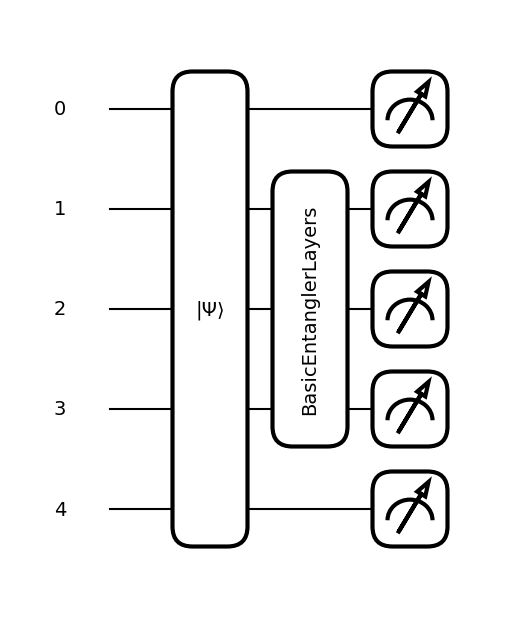

In [14]:
num_qubits = 5
params_shape = qml.BasicEntanglerLayers.shape(n_layers=2, n_wires=3)
params = np.random.random(size=params_shape)

def ansatz(params):

    basis = [1] + [0]*(num_qubits-1)
    qml.BasisState(basis, wires=range(num_qubits))
            
    qml.BasicEntanglerLayers(params, wires=range(num_qubits-4, num_qubits-1), rotation=qml.RY)
            
    return qml.state()

qml.draw_mpl(ansatz)(params)

In [24]:
list(range(num_qubits-4,num_qubits-1))

[1, 2, 3]

(<Figure size 900x600 with 1 Axes>, <Axes: >)

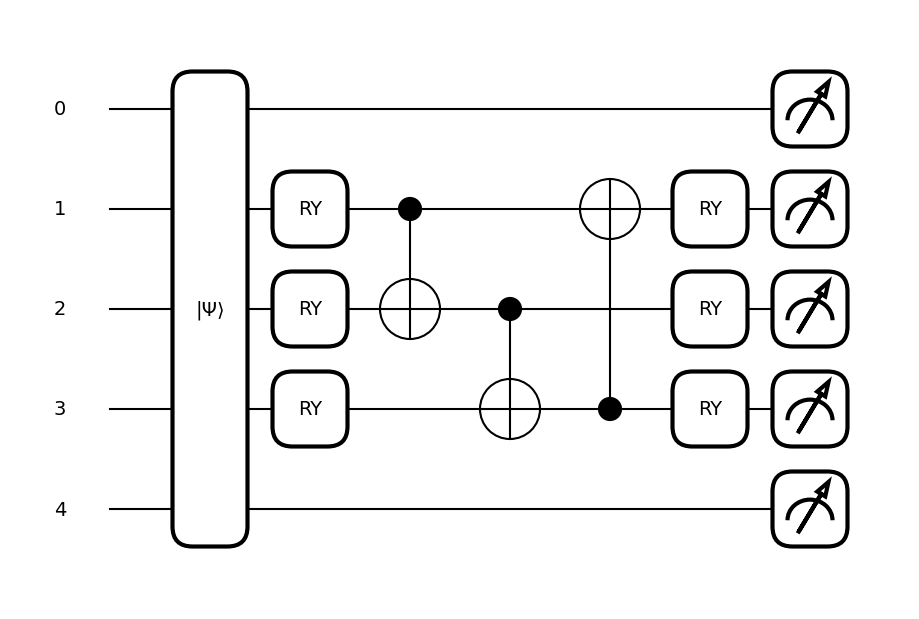

In [26]:
num_qubits   = 5
params = np.random.random(size=2*num_qubits)

def ansatz(params):

    basis = [1] + [0]*(num_qubits-1)
    qml.BasisState(basis, wires=range(num_qubits))

    block = list(range(num_qubits-4,num_qubits-1))

    param_index = 0
    for i in block:
        qml.RY(params[param_index], wires=i)
        param_index += 1

    # Circular entanglement only on qubits 1, 2, 3
    for idx, q in enumerate(block):
        q_next = block[(idx + 1) % len(block)]
        qml.CNOT(wires=[q, q_next])

    # Second layer of single-qubit rotations on all qubits
    for k in block:
        qml.RY(params[param_index], wires=k)
        param_index += 1

    return qml.state()

# draw the circuit
qml.draw_mpl(ansatz)(params)


In [2]:
cutoff = 8
potential = 'AHO'

In [3]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cutoff, potential)
eigenvalues, eigenvectors = np.linalg.eig(H)

min_index = np.argmin(eigenvalues)
min_eigenvalue = eigenvalues[min_index]
min_eigenvector = eigenvectors[:, min_index]

In [4]:
min_eigenvector

array([ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  9.76235111e-01+0.j,
       -1.19470688e-15+0.j, -2.14219863e-01+0.j,  1.06461846e-16+0.j,
        3.26181440e-02+0.j,  3.84766120e-17+0.j,  3.30368125e-03+0.j,
       -1.86127527e-17+0.j])

In [5]:
min_eigenvalue

np.complex128(0.03201011000921177+0j)

In [6]:
#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [30]:
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
dev = qml.device('default.qubit', wires=num_qubits, shots=1024)
@qml.qnode(dev)
def ansatz(params):
    
    #qml.RY(params[0], wires=[0])
    #qml.RY(params[1], wires=[num_qubits-2])
    # Define the parameterized ansatz
        
    qml.StronglyEntanglingLayers(params, wires=range(num_qubits), imprimitive=qml.CZ)
            
    return qml.probs()#qml.state()#

In [8]:
dev = qml.device('default.qubit', wires=num_qubits)
@qml.qnode(dev)
def ansatz_e(params):
    
    #qml.RY(params[0], wires=[0])
    #qml.RY(params[1], wires=[num_qubits-2])
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    qml.StronglyEntanglingLayers(params, wires=range(num_qubits), imprimitive=qml.CZ)
    
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

In [9]:
def cost_function(params):
    
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    #params = pnp.tensor(params, requires_grad=True)
    ansatz_state = ansatz(params)

    overlap = np.vdot(min_eigenvector, ansatz_state)
    overlap_squared = np.abs(overlap)**2  

    return (1 - overlap_squared)

In [43]:
ansatz_prob = ansatz(pnp.tensor(hres.x.reshape(params_shape), requires_grad=True))
ansatz_prob

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.953125, 0.      , 0.046875, 0.      ,
       0.      , 0.      , 0.      , 0.      ])

In [44]:
min_eigenvector_prob = np.abs(min_eigenvector)**2
min_eigenvector_prob

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.53034993e-01, 1.42732453e-30, 4.58901495e-02, 1.13341246e-32,
       1.06394332e-03, 1.48044967e-33, 1.09143098e-05, 3.46434562e-34])

In [46]:
min_eigenvector_prob*ansatz_prob

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.90836148, 0.        ,
       0.0021511 , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [47]:
np.sqrt(min_eigenvector_prob*ansatz_prob)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.95308   , 0.        ,
       0.04637996, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [45]:
np.sum(np.sqrt(min_eigenvector_prob*ansatz_prob))

np.float64(0.9994599561083781)

In [48]:
def cost_function_hellinger(params):
    
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    #params = pnp.tensor(params, requires_grad=True)
    ansatz_state = ansatz(params)

    min_eigenvector_prob = np.abs(min_eigenvector)**2
    #ansatz_prob = np.abs(ansatz_state)**2
    ansatz_prob = ansatz_state

    hellinger_fidelity = np.sum((min_eigenvector_prob*ansatz_prob))

    return (1 - hellinger_fidelity)


In [32]:
def cost_function_hellinger(params):
    # Convert params to a tensor and ensure gradients are tracked.
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    
    # Compute the ansatz state and ensure it is normalized.
    ansatz_state = ansatz(params)
    #ansatz_state = ansatz_state / pnp.linalg.norm(ansatz_state)
    #ansatz_prob = pnp.abs(ansatz_state) ** 2
    ansatz_prob = ansatz_state
    
    # Convert min_eigenvector to a tensor (if not already) and normalize it.
    min_eigenvector_tensor = pnp.tensor(min_eigenvector, dtype=ansatz_state.dtype)
    min_eigenvector_tensor = min_eigenvector_tensor / pnp.linalg.norm(min_eigenvector_tensor)
    min_eigenvector_prob = pnp.abs(min_eigenvector_tensor) ** 2

    # Compute the Hellinger fidelity (or Bhattacharyya coefficient).
    hellinger_fidelity = pnp.sum(pnp.sqrt(ansatz_prob * min_eigenvector_prob))

    # Return the cost (1 - fidelity), which will be 0 if the distributions are identical.
    return 1 - hellinger_fidelity


In [56]:
x0 = np.random.random(params_shape).flatten()
#x0 = np.random.rand(2)*2*np.pi
''''
res = minimize(
    cost_function,
    x0,
    method= "COBYLA",
    options= {'maxiter':10000}
)
'''
hres = minimize(
    cost_function_hellinger,
    x0,
    method= "COBYLA",
    options= {'maxiter':10000, 'tol':1e-12}
)

#print(res, hres)

In [57]:
res.fun

np.float64(1.4154986933689884e-05)

In [58]:
params = hres.x
ansatz_e(params)

tensor(0.83093615, requires_grad=True)

In [59]:
#bounds = [(0, 2 * np.pi) for _ in range(2)]
bounds = [(0, 2 * np.pi) for _ in range(np.prod(params_shape))]
'''
res = differential_evolution(cost_function,
                                    bounds,
                                    maxiter=10000,
                                    tol=1e-3,
                                    atol=1e-3,
                                    strategy='randtobest1bin',
                                    popsize=20
                                    )
'''
hres = differential_evolution(cost_function_hellinger,
                                    bounds,
                                    maxiter=10000,
                                    tol=1e-3,
                                    atol=1e-3,
                                    strategy='randtobest1bin',
                                    popsize=20
                                    )

#print(res, hres)

In [60]:
params = hres.x
ansatz_e(params)

tensor(1.06848217, requires_grad=True)

In [245]:
dev = qml.device('default.qubit', wires=num_qubits, shots=None)
@qml.qnode(dev)
def circuit(params):
    
    qml.RY(params[0], wires=[0])
    qml.RY(params[1], wires=[num_qubits-2])
    
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits))) 

In [246]:
circuit(res.x)

np.float64(0.8705798402842357)

In [ ]:
[ 4.486e+00  4.930e+00]
[ 3.149e+00  5.731e+00]

In [ ]:
data = []

for potential in ['QHO', 'AHO', 'DW']:
    for cutoff in [2, 4, 8, 16, 32, 64]:

        #calculate Hamiltonian and expected eigenvalues
        H = calculate_Hamiltonian(cutoff, potential)
        eigenvalues, eigenvectors = np.linalg.eig(H)

        min_index = np.argmin(eigenvalues)
        min_eigenvalue = eigenvalues[min_index]
        min_eigenvector = eigenvectors[:, min_index]

        #create qiskit Hamiltonian Pauli string
        hamiltonian = SparsePauliOp.from_operator(H)
        num_qubits = hamiltonian.num_qubits

        num_layers = 1
        params_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)
        x0 = np.random.random(params_shape).flatten()

        # Initialize device
        dev = qml.device("default.qubit", wires=num_qubits)

        # Define the parameterized ansatz
        @qml.qnode(dev)
        def ansatz(params):
            qml.StronglyEntanglingLayers(params, wires=range(num_qubits), imprimitive=qml.CZ)
            return qml.state()  # Return the statevector
        
        def cost_function(params):

            params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
            ansatz_state = ansatz(params)

            overlap = np.vdot(min_eigenvector, ansatz_state)
            overlap_squared = np.abs(overlap)**2  

            return (1 - overlap_squared)
        
        def cost_function_hellinger(params):

            params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
            ansatz_state = ansatz(params)

            min_eigenvector_prob = np.abs(min_eigenvector)**2
            ansatz_prob = np.abs(ansatz_state)**2

            hellinger_fidelity = np.sum(np.sqrt(min_eigenvector_prob * ansatz_prob))

            return (1 - hellinger_fidelity)
        

        overlap_res = minimize(
            cost_function,
            x0,
            method= "COBYLA",
            options= {'maxiter':10000, 'tol': 1e-8}
        )

        hellinger_res = minimize(
            cost_function_hellinger,
            x0,
            method= "COBYLA",
            options= {'maxiter':10000, 'tol': 1e-8}
        )

        row_data = {'potential': potential, 'cutoff': cutoff, 'overlap': overlap_res.fun, 'hellinger': hellinger_res.fun}

        data.append(row_data)     

In [ ]:
pd.DataFrame(data)

## Real Amplitudes

In [ ]:
cutoff = 128
potential = 'AHO'

In [ ]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cutoff, potential)
eigenvalues, eigenvectors = np.linalg.eig(H)

min_index = np.argmin(eigenvalues)
min_eigenvalue = eigenvalues[min_index]
min_eigenvector = eigenvectors[:, min_index]

In [ ]:
#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [ ]:
# Parameters
repetition = 1

# Initialize device
dev = qml.device("default.qubit", wires=num_qubits)
    
# Define the ansatz circuit
@qml.qnode(dev)
def real_amplitudes(params, repetition, num_qubits):
    param_index = 0
    for _ in range(repetition):

        # Apply RY rotations
        for i in range(num_qubits):
            qml.RY(params[param_index], wires=i)
            param_index += 1

        # Apply entanglement
        for j in reversed(range(1, num_qubits)):  # Reverse linear entanglement
            qml.CNOT(wires=[j - 1, j])

        # Apply RY rotations
        for k in range(num_qubits):
            qml.RY(params[param_index], wires=k)
            param_index += 1

    return qml.state()

# Number of parameters required for this ansatz
n_params = repetition * 2*num_qubits
params = np.random.uniform(0, 2 * np.pi, size=n_params)


In [ ]:
@qml.qnode(dev)
def circuit(params):
    param_index=0
    for i in range(0, num_qubits-2):
        qml.RY(params[param_index], wires=i)
        param_index += 1

    # Apply entanglement
    for j in reversed(range(1, num_qubits-2)):
        qml.CNOT(wires=[j - 1, j])

    # Apply RY rotations
    for k in range(0, num_qubits-2):
        qml.RY(params[param_index], wires=k)
        param_index += 1
    
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))     

In [ ]:
n_params = repetition * 2*num_qubits
params = np.random.uniform(0, 2 * np.pi, size=n_params)
drawer = qml.draw(circuit)
print(drawer(params))

In [ ]:
drawer = qml.draw(real_amplitudes)
print(drawer(params, repetition, num_qubits))

In [ ]:
def cost_function(params):

    ansatz_state = real_amplitudes(params, repetition, num_qubits)

    overlap = np.vdot(min_eigenvector, ansatz_state)
    overlap_squared = np.abs(overlap)**2  

    return (1 - overlap_squared)

In [ ]:
def cost_function_hellinger(params):

    ansatz_state = real_amplitudes(params, repetition, num_qubits)

    min_eigenvector_prob = np.abs(min_eigenvector)**2
    ansatz_prob = np.abs(ansatz_state)**2

    hellinger_fidelity = np.sum(np.sqrt(min_eigenvector_prob * ansatz_prob))

    return (1 - hellinger_fidelity)


In [ ]:
x0 = np.random.uniform(0, 2 * np.pi, size=n_params)

res = minimize(
    cost_function,
    x0,
    method= "COBYLA",
    options= {'maxiter':10000, 'tol': 1e-8}
)


In [ ]:
data = []

repetition = 1

for potential in ['QHO', 'AHO', 'DW']:
    for cutoff in [2, 4, 8, 16, 32, 64]:

        #calculate Hamiltonian and expected eigenvalues
        H = calculate_Hamiltonian(cutoff, potential)
        eigenvalues, eigenvectors = np.linalg.eig(H)

        min_index = np.argmin(eigenvalues)
        min_eigenvalue = eigenvalues[min_index]
        min_eigenvector = eigenvectors[:, min_index]

        #create qiskit Hamiltonian Pauli string
        hamiltonian = SparsePauliOp.from_operator(H)
        num_qubits = hamiltonian.num_qubits
        n_params = repetition * 2*num_qubits

        x0 = np.random.uniform(0, 2 * np.pi, size=n_params)

        # Initialize device
        dev = qml.device("default.qubit", wires=num_qubits)

        # Define the ansatz circuit
        @qml.qnode(dev)
        def real_amplitudes(params, repetition, num_qubits):
            param_index = 0
            for _ in range(repetition):

                # Apply RY rotations
                for i in range(num_qubits):
                    qml.RY(params[param_index], wires=i)
                    param_index += 1

                # Apply entanglement
                for j in reversed(range(1, num_qubits)):  # Reverse linear entanglement
                    qml.CNOT(wires=[j - 1, j])

                # Apply RY rotations
                for k in range(num_qubits):
                    qml.RY(params[param_index], wires=k)
                    param_index += 1

            return qml.state()

        overlap_res = minimize(
            cost_function,
            x0,
            method= "COBYLA",
            options= {'maxiter':10000, 'tol': 1e-8}
        )

        hellinger_res = minimize(
            cost_function_hellinger,
            x0,
            method= "COBYLA",
            options= {'maxiter':10000, 'tol': 1e-8}
        )

        row_data = {'potential': potential, 'cutoff': cutoff, 'overlap': overlap_res.fun, 'hellinger': hellinger_res.fun}

        data.append(row_data)     

In [ ]:
pd.DataFrame(data)

In [ ]:
data = []

repetition = 1

#variables
max_iter = 10000
strategy = "randtobest1bin"
tol = 1e-3
abs_tol = 1e-3
popsize = 20

for potential in ['QHO', 'AHO', 'DW']:
    for cutoff in [2]:#, 4, 8, 16, 32, 64]:

        #calculate Hamiltonian and expected eigenvalues
        H = calculate_Hamiltonian(cutoff, potential)
        eigenvalues, eigenvectors = np.linalg.eig(H)

        min_index = np.argmin(eigenvalues)
        min_eigenvalue = eigenvalues[min_index]
        min_eigenvector = eigenvectors[:, min_index]

        #create qiskit Hamiltonian Pauli string
        hamiltonian = SparsePauliOp.from_operator(H)
        num_qubits = hamiltonian.num_qubits
        n_params = repetition * 2*num_qubits

        bounds = [(0, 2 * np.pi) for _ in range(n_params)]
        # Initialize device
        dev = qml.device("default.qubit", wires=num_qubits)

        # Define the ansatz circuit
        @qml.qnode(dev)
        def real_amplitudes(params, repetition, num_qubits):
            param_index = 0
            for _ in range(repetition):

                # Apply RY rotations
                for i in range(num_qubits):
                    qml.RY(params[param_index], wires=i)
                    param_index += 1

                # Apply entanglement
                for j in reversed(range(1, num_qubits)):  # Reverse linear entanglement
                    qml.CNOT(wires=[j - 1, j])

                # Apply RY rotations
                for k in range(num_qubits):
                    qml.RY(params[param_index], wires=k)
                    param_index += 1

            return qml.state()

        overlap_res = differential_evolution(
            cost_function,
            bounds,
            maxiter=max_iter,
            tol=tol,
            atol=abs_tol,
            strategy=strategy,
            popsize=popsize
        )

        hellinger_res = differential_evolution(
            cost_function_hellinger,
            bounds,
            maxiter=max_iter,
            tol=tol,
            atol=abs_tol,
            strategy=strategy,
            popsize=popsize
        )

        row_data = {'potential': potential, 'cutoff': cutoff, 'overlap': overlap_res.fun, 'hellinger': hellinger_res.fun}

        data.append(row_data)     

In [ ]:
pd.DataFrame(data)